In [1]:
import numpy as np
import pandas as pd

# 1.1 Set up the data

To start working download the banking dataset on Kaggle.

In [2]:
data = pd.read_csv("bank_transactions.csv")

In [3]:
data  #to visualize the dataset as it is provided.

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.0
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.0
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.0
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.0


For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

In [4]:
#In order to compare the data provided with that of the query in question 1.3 we drop the 'TransactionID' and 'CustomerID' columns.
data2 = data.drop(['TransactionID','CustomerID'],axis=1)

#We change the name of the column just for simplicity.
data2['TransactionAmount']=data2['TransactionAmount (INR)']
data2 = data2.drop(['TransactionAmount (INR)'],axis=1)

#We change the format of clients' date of birth so that they can be more processable.
#In addition, we create a new column with the customers' dates of birth.
data2.CustomerDOB = pd.to_datetime(data2.CustomerDOB)
data2.loc[data2.CustomerDOB.dt.year > 2000, "CustomerDOB"] = data2.loc[data2.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
data2.drop(data[data2.CustomerDOB.dt.year == 1800].index, axis = 0, inplace = True)
np.timedelta64(1, "Y")
data2['CustomerAge'] = (( pd.to_datetime('today') - data2.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

#We round up the remaining customer transaction information so that it can be meaningfully compared with each other.
data2.TransactionAmount=data2.TransactionAmount.apply(lambda x: x//500*500)
data2.CustAccountBalance=data2.CustAccountBalance.apply(lambda x: x//10000*10000)
data2.TransactionTime=data2.TransactionTime.apply(lambda x: round(x/10000,0))
data2.CustomerAge=data2.CustomerAge.apply(lambda x: x//5*5)

In [16]:
data2 #to visualize the dataset ready to be processed.

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,CustomerAge
0,1994-10-01,F,JAMSHEDPUR,10000.0,2/8/16,14.0,0.0,20.0
1,1957-04-04,M,JHAJJAR,0.0,2/8/16,14.0,27500.0,60.0
2,1996-11-26,F,MUMBAI,10000.0,2/8/16,14.0,0.0,20.0
3,1973-09-14,F,MUMBAI,860000.0,2/8/16,14.0,2000.0,40.0
4,1988-03-24,F,NAVI MUMBAI,0.0,2/8/16,18.0,1500.0,30.0
...,...,...,...,...,...,...,...,...
1048562,1990-08-04,M,NEW DELHI,0.0,18/9/16,18.0,500.0,30.0
1048563,1992-02-20,M,NASHIK,20000.0,18/9/16,18.0,0.0,30.0
1048564,1989-05-18,M,HYDERABAD,220000.0,18/9/16,18.0,500.0,30.0
1048565,1978-08-30,M,VISAKHAPATNAM,10000.0,18/9/16,18.0,1000.0,40.0


# 1.2 Fingerprint hashing

Implement your minhash function from scratch. No ready-made hash functions are allowed. Read the class material and search the internet if you need to. For reference, it may be practical to look at the description of hash functions in the book.

In [17]:
data2.dropna(inplace=True) #we remove all transactions with missing information.

In [18]:
#We define a function that generates an arbitrary number of permutations of an array provided as input.
#This function will be used to implement the minhash function.
def permutations(arr,n_perm):
    index=np.array([i for i in range(len(arr))])
    perms=[]
    for i in range(n_perm):
        perms.append(np.random.permutation(index))
    return perms

In [19]:
#This function is used to apply the minhash procedure to a single column
#and then iterate it to all the columns in the matrix with the same permutations.
def minhash(arr,perms):
    n_perm=len(perms)
    sign = np.zeros(n_perm+1)  #column initialized with all zeros
    i = 0
    #I see what position the first non-zero element is in
    while arr[i] == 0:
        i += 1
    sign[0] = i+1
    for i in range(n_perm):
        #Make the permutation
        for j in range(len(arr)):
            temp=arr[j]
            arr[j] = arr[perms[i][j]]
            arr[perms[i][j]]=temp
        k = 0
        #I see what position the first non-zero element is in
        while k!=len(arr) and arr[k] == 0:
            k += 1
        sign[i+1] = k+1
    return sign

Process the dataset and add each record to the MinHash. The subtask's goal is to try and map each consumer to its bin; to ensure this works well, be sure you understand how MinHash works and choose a matching threshold to use. Before moving on, experiment with different thresholds, explaining your choice.

In [20]:
#I delete duplicates from each column to get all the different options once
CustomerAge_norep=list(data2.CustomerAge.drop_duplicates())
CustGender_norep=['M','F']
CustAccountBalance_norep=list(data2.CustAccountBalance.drop_duplicates())
TransactionDate_norep=list(data2.TransactionDate.drop_duplicates())
TransactionTime_norep=list(data2.TransactionTime.drop_duplicates())
TransactionAmount_norep=list(data2.TransactionAmount.drop_duplicates())

In [27]:
#I create the shingles column
shi=[]
for i in  range(len(data2)):
    if i<len(CustomerAge_norep):
        shi.append(CustomerAge_norep[i])
    if i<len(CustGender_norep):
        shi.append(CustGender_norep[i]) 
    if i<len(CustAccountBalance_norep):
        shi.append(CustAccountBalance_norep[i]) 
    if i<len(TransactionDate_norep):
        shi.append(TransactionDate_norep[i]) 
    if i<len(TransactionTime_norep):
        shi.append(TransactionTime_norep[i]) 
    if i<len(TransactionAmount_norep):
        shi.append(TransactionAmount_norep[i])   

In [28]:
perms=permutations(shi,11)
sign_matrix=np.zeros([12,1048567])
for i in data2.index: #I repeat for all transactions
    #I create the column to apply the minhash function to using the shingles column
    a=[data2.CustomerAge[i], data2.CustGender[i], data2.CustAccountBalance[i], data2.TransactionDate[i], data2.TransactionTime[i], data2.TransactionAmount[i]]
    b=np.zeros(len(shi))
    for j in range(len(shi)):
        if shi[j] in a:
            b[j]=1
    c=minhash(b,perms) #I apply the minhash function
    #I insert the column in the signature matrix
    for j in range(12):
        sign_matrix[j][i]=c[j]

In [29]:
#Columns in which there was missing information are deleted
lista=[]
for i in range(1048567):
    if i not in data2.index:
        lista.append(i)
count=0
for i in lista:
    sign_matrix=np.delete(sign_matrix,i-count,1)
    count+=1

In [30]:
#I create an index for each column
n_tr=len(sign_matrix[1])
ind_tr=np.arange(n_tr)
sign_matrix=np.r_[[ind_tr],sign_matrix]
sign_matrix= sign_matrix.astype(int)

In [ ]:
bands=[]
buckets=[[]] #list of lists representing the different buckets
for i in [0,3,6,9]: #band size = 3
    for j in range(n_tr):
        q=0
        for k in range(len(bands)):
            #Check if there is a band equal to the current one
            if [sign_matrix[1+i][j],sign_matrix[2+i][j],sign_matrix[3+i][j]]==bands[k]:
                buckets[k].append(sign_matrix[0][j]) #to put the transaction of the corresponding bucket
                q+=1 #indicates that an equal band was found
            if q==0: #if q==0 no band like the current one was found
                bands.append([sign_matrix[1+i][j],sign_matrix[2+i][j],sign_matrix[3+i][j]])

# 1.3 Locality Sensitive Hashing

In [74]:
query = pd.read_csv("query_users.csv")
query.dropna(inplace=True)

In [75]:
query

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,27/7/78,M,DELHI,94695.61,2/9/16,140310,65.00
1,6/11/92,M,PANCHKULA,7584.09,2/9/16,120214,6025.00
2,14/8/91,M,PATNA,7180.60,10/8/16,221732,541.50
3,3/1/87,M,CHENNAI,56847.75,29/8/16,144138,1000.00
4,4/1/95,M,GURGAON,84950.13,25/9/16,233309,80.00
5,10/1/81,M,WORLD TRADE CENTRE BANGALORE,23143.95,11/9/16,192906,303.00
6,20/9/76,F,CHITTOOR,15397.80,28/8/16,92633,20.00
7,10/4/91,M,MOHALI,426.30,2/8/16,203754,50.00
8,19/3/90,M,MOHALI,4609.34,26/8/16,184015,300.00
9,19/12/70,M,SERAMPORE,6695988.46,27/8/16,144030,299.00


In [76]:
#The query data is processed in the same way as the data in the Kaggle dataset
query['TransactionAmount']=query['TransactionAmount (INR)']
query = query.drop(['TransactionAmount (INR)'],axis=1)
query.CustomerDOB = pd.to_datetime(query.CustomerDOB)
query.loc[query.CustomerDOB.dt.year > 2000, "CustomerDOB"] = query.loc[query.CustomerDOB.dt.year > 2000, 'CustomerDOB'] - pd.DateOffset(years = 100)
query.drop(query[query.CustomerDOB.dt.year == 1800].index, axis = 0, inplace = True)
np.timedelta64(1, "Y")
query['CustomerAge'] = (( pd.to_datetime('today') - query.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)
query.TransactionAmount=query.TransactionAmount.apply(lambda x: x//500*500)
query.CustAccountBalance=query.CustAccountBalance.apply(lambda x: x//10000*10000)
query.TransactionTime=query.TransactionTime.apply(lambda x: round(x/10000,0))
query.CustomerAge=query.CustomerAge.apply(lambda x: x//5*5)

In [77]:
CustomerAge_norep_query=list(query.CustomerAge.drop_duplicates())
CustGender_norep_query=['M','F']
CustAccountBalance_norep_query=list(query.CustAccountBalance.drop_duplicates())
TransactionDate_norep_query=list(query.TransactionDate.drop_duplicates())
TransactionTime_norep_query=list(query.TransactionTime.drop_duplicates())
TransactionAmount_norep_query=list(query.TransactionAmount.drop_duplicates())

In [78]:
query #to visualize the dataset ready to be processed.

,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,CustomerAge
0,1978-07-27,M,DELHI,90000.0,2/9/16,14.0,0.0,40.0
1,1992-06-11,M,PANCHKULA,0.0,2/9/16,12.0,6000.0,30.0
2,1991-08-14,M,PATNA,0.0,10/8/16,22.0,500.0,30.0
3,1987-03-01,M,CHENNAI,50000.0,29/8/16,14.0,1000.0,35.0
4,1995-04-01,M,GURGAON,80000.0,25/9/16,23.0,0.0,25.0
5,1981-10-01,M,WORLD TRADE CENTRE BANGALORE,20000.0,11/9/16,19.0,0.0,40.0
6,1976-09-20,F,CHITTOOR,10000.0,28/8/16,9.0,0.0,45.0
7,1991-10-04,M,MOHALI,0.0,2/8/16,20.0,0.0,30.0
8,1990-03-19,M,MOHALI,0.0,26/8/16,18.0,0.0,30.0
9,1970-12-19,M,SERAMPORE,6690000.0,27/8/16,14.0,0.0,50.0


In [35]:
shi_query=[]
for i in  range(len(query)):
    if i<len(CustomerAge_norep_query):
        shi_query.append(CustomerAge_norep_query[i])
    if i<len(CustGender_norep_query):
        shi_query.append(CustGender_norep_query[i]) 
    if i<len(CustAccountBalance_norep_query):
        shi_query.append(CustAccountBalance_norep_query[i]) 
    if i<len(TransactionDate_norep_query):
        shi_query.append(TransactionDate_norep_query[i]) 
    if i<len(TransactionTime_norep_query):
        shi_query.append(TransactionTime_norep_query[i]) 
    if i<len(TransactionAmount_norep_query):
        shi_query.append(TransactionAmount_norep_query[i])   

In [65]:
#I proceed in the same way as in Kaggle's dataset.
perms=permutations(shi_query,5)
sign_matrix_query=np.zeros([6,50])
for i in query.index:
    a=[query.CustomerAge[i], query.CustGender[i], query.CustAccountBalance[i], query.TransactionDate[i], query.TransactionTime[i], query.TransactionAmount[i]]
    b=np.zeros(len(shi_query))
    for j in range(len(shi_query)):
        if shi_query[j] in a:
            b[j]=1
    c=minhash(b,perms)
    for j in range(6):
        sign_matrix_query[j][i]=c[j]

In [61]:
sign_matrix_query

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
       [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
        32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
       [ 1,  2,  2,  2,  2,  1,  6,  2,  2,  2,  2,  2,  1,  7,  2,  6,
         2,  2,  1,  8,  2,  2,  2,  2,  2,  2,  2,  2,  2,  5,  2,  6,
         2,  2,  2,  2,  2,  2,  1,  6,  2,  6,  2,  2,  6,  2],
       [ 3,  3,  3,  6,  3,  3,  3,  3,  3,  3,  3,  3,  5, 10,  1,  3,
         3,  3,  7,  1,  3, 12,  3, 10, 11,  3,  3, 25, 12, 25, 11,  3,
         8,  3, 10,  1,  3,  1, 23,  3,  3,  2,  3,  3,  3,  3],
       [ 3,  3,  3,  9,  3,  3,  3,  3,  3,  3,  1,  3, 18, 10,  3,  3,
         3,  3,  6,  9,  3,  2,  3, 10, 19,  3,  3,  9,  2,  9, 19,  3,
         2,  3, 10, 

In [66]:
lista=[]
for i in range(50):
    if i not in query.index:
        lista.append(i)
count=0
for i in lista:
    sign_matrix_query=np.delete(sign_matrix_query,i-count,1)
    count+=1

In [71]:
n_tr=46
ind_tr=np.arange(n_tr)
sign_matrix_query=np.r_[[ind_tr],sign_matrix_query]
sign_matrix_query= sign_matrix_query.astype(int)

In [72]:
bands_query=[[sign_matrix_query[1][0],sign_matrix_query[2][0]]]
buckets_query=[[]]
for i in [0,2,4]:
    for j in range(n_tr):
        q=0
        for k in range(len(bands_query)):
            if [sign_matrix_query[1+i][j],sign_matrix_query[2+i][j]]==bands_query[k]:
                buckets_query[k].append(sign_matrix_query[0][j])
                q+=1
            if q==0:
                bands_query.append([sign_matrix_query[1+i][j],sign_matrix_query[2+i][j]])

MemoryError: 

# 2. Grouping customers together!

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np

In [ ]:
data = pd.read_csv("bank_transactions.csv")

In [ ]:
data.TransactionDate  = pd.to_datetime(data.TransactionDate)

In [ ]:
def convert_time(value):
    sec = str(value % 100)
    minutes = str((value //100) %100)
    hours = str((value // 10000) %100)
    return datetime.strptime(str(hours)+":"+str(minutes)+":"+str(sec), '%H:%M:%S').time()

In [ ]:
data.TransactionTime = data.TransactionTime.apply(lambda row: convert_time(row))

In [ ]:
data.TransactionDate = pd.to_datetime(data.TransactionDate)

In [ ]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),difference,n_significant_transactions,n_normal_transactions,early,late
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,14:32:07,25.0,17794.05,0,1,0,1
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2016-02-08,14:18:58,27999.0,-25728.31,1,0,0,1
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-02-08,14:27:12,459.0,17415.44,0,0,0,1
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-02-08,14:27:14,2060.0,864443.21,0,1,0,1
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,18:11:56,1762.5,4951.93,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,2016-09-18,18:48:24,799.0,6836.19,1,0,0,1
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,2016-09-18,18:37:34,460.0,26851.42,0,0,0,1
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,2016-09-18,18:33:13,770.0,220987.06,0,1,0,1
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,2016-09-18,18:47:06,1000.0,9117.87,0,0,0,1


The 7 features recommended in the homework are the following:

a) Number of transactions: *n_transactions*

b) Number of transactions with a balance bigger than 100 USD: *n_transactions_100*

c) Average amount of the transactions: *average_amount*

d) Average balance: *average_balance*

e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation): *utilisation*

f) Most common gender of the customer: *common_gender*

h) Most frequent location of the customer: *frequent_location*

### 2.1 Getting your data + feature engineering

In [ ]:
transactions = data.groupby(['CustomerID'])['CustomerID'].count().reset_index(name='n_transactions')

In [ ]:
trans_100 = data.groupby(['CustomerID'])["TransactionAmount (INR)"].apply(lambda x: (x>100).sum()).reset_index(name='n_transactions_100')

In [ ]:
features = pd.merge(transactions,trans_100, on="CustomerID")

In [ ]:
amount= data.groupby(['CustomerID'])["TransactionAmount (INR)"].mean().reset_index(name='average_amount')

In [ ]:
features = pd.merge(features,amount, on="CustomerID")

In [ ]:
av_balance= data.groupby(['CustomerID'])["CustAccountBalance"].mean().reset_index(name='average_balance')

In [ ]:
features = pd.merge(features, av_balance, on="CustomerID")

In [ ]:
data['difference'] = data["CustAccountBalance"] - data["TransactionAmount (INR)"]

In [ ]:
utilisation = data.groupby(["CustomerID"])["difference"].mean().reset_index(name='utilisation')

In [ ]:
features = pd.merge(features, utilisation, on="CustomerID")

In [ ]:
gender= data.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode).reset_index(name='common_gender')

In [ ]:
features = pd.merge(features,gender, on="CustomerID")

In [ ]:
freq_location= data.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode).reset_index(name='frequent_location')

In [ ]:
features = pd.merge(features,freq_location, on="CustomerID")

In [ ]:
features

,CustomerID,n_transactions,n_transactions_100,average_amount,average_balance,utilisation,common_gender,frequent_location
0,C1010011,2,2,2553.0,76340.635,73787.635,"[F, M]","[NEW DELHI, NOIDA]"
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI
2,C1010014,2,2,727.5,100112.950,99385.450,"[F, M]",MUMBAI
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA
...,...,...,...,...,...,...,...,...
884260,C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI
884261,C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE
884262,C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR
884263,C9099941,1,0,50.0,35295.920,35245.920,M,CHENNAI


## Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

The following features are 20 additional features that can be generated for each CustomerId:

1) The minimum TransactionAmount (INR): *min_trans*

2) The maximum TransactionAmount (INR): *max_trans*

3) The minimum CustAccountBalance: *min_accountbalance*

4) The maximum CustAccountBalance: *max_accountbalance*

5) Number of CustAccountBalance with an overall higher than 50000 USD: *account_balance_sup50k*

6) Number of CustAccountBalance with an overall lower than 10000 USD: *account_balance_low10k*

7) The earlier TransactionTime: *earlier_TransactionTime*

8) The latest TransactionTime: *latest_TransactionTime*

9) Amount of the average amount of the transaction on the average account balance: *percentage_of_expenditure*

10) Number of transactions (per person) with a percentage of expenditure greater or equal to 10%: *n_significant_transactions*

11) Number of transaction (per person) with a percentage of expenditure lower or equal to 1%: *n_normal_transactions*

12) Account balance range: *acc_bal_range*

13) Utilisation on average account balance: *percent_availability*

14) Number of transactions in the first half of the day

15) Number of transactions in the second half of the day

16) Number of transactions in the first half of the year

17) Number of transactions in the second half of the year

18) TransactionAmount (INR) median

19) TransactionAmount (INR) first quartile

20) TransactionAmount (INR) third quartile

### Minimum and maximum TransactionAmount (INR)

In [ ]:
min_trans= data.groupby(['CustomerID'])["TransactionAmount (INR)"].min().reset_index(name='min_trans')

In [ ]:
features = pd.merge(features,min_trans, on="CustomerID")

In [ ]:
max_trans= data.groupby(['CustomerID'])["TransactionAmount (INR)"].max().reset_index(name='max_trans')

In [ ]:
features = pd.merge(features, max_trans, on="CustomerID")

### Minimum and Maximum CustAccountBalance

In [ ]:
min_account= data.groupby(['CustomerID'])["CustAccountBalance"].min().reset_index(name='min_accountbalance')

In [ ]:
features = pd.merge(features, min_account, on="CustomerID")

In [ ]:
max_account= data.groupby(['CustomerID'])["CustAccountBalance"].max().reset_index(name='max_accountbalance')

In [ ]:
features = pd.merge(features, max_account, on="CustomerID")

### Number of CustAccountBalance with an overall higher than 50000 USD: *account_balance_sup50k*

In [ ]:
account_balance_sup500k = data.groupby(['CustomerID'])["CustAccountBalance"].apply(lambda x: (x>50000).sum()).reset_index(name='account_balance_sup50k')

In [ ]:
features = pd.merge(features, account_balance_sup500k, on="CustomerID")

### Number of CustAccountBalance with an overall lower than 10000 USD: *account_balance_low10k*

In [ ]:
account_balance_low10k = data.groupby(['CustomerID'])["CustAccountBalance"].apply(lambda x: (x<10000).sum()).reset_index(name='account_balance_low10k')

In [ ]:
features = pd.merge(features, account_balance_low10k, on="CustomerID")

### Earliest and latest TransactionTime

In [ ]:
earliest_TransactionTime= data.groupby(['CustomerID'])["TransactionTime"].min().reset_index(name='earliest_TransactionTime')

In [ ]:
features = pd.merge(features, earliest_TransactionTime, on="CustomerID")

In [ ]:
latest_TransactionTime= data.groupby(['CustomerID'])["TransactionTime"].max().reset_index(name='latest_TransactionTime')

In [ ]:
features = pd.merge(features, latest_TransactionTime, on="CustomerID")

### Amount of the average amount of the transaction on the average account balance: *percentage_of_expenditure*

In [ ]:
features['percentage_of_expenditure']=round((features['average_amount']/features['average_balance'])*100, 2)

In [ ]:
features

,CustomerID,n_transactions,n_transactions_100,average_amount,average_balance,utilisation,common_gender,frequent_location,min_trans,max_trans,min_accountbalance,max_accountbalance,account_balance_sup50k,account_balance_low10k,earliest_TransactionTime,latest_TransactionTime,percentage_of_expenditure
0,C1010011,2,2,2553.0,76340.635,73787.635,"[F, M]","[NEW DELHI, NOIDA]",356.0,4750.0,32500.73,120180.54,1,0,11229,123813,3.34
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,24204.49,24204.49,0,0,204409,204409,6.19
2,C1010014,2,2,727.5,100112.950,99385.450,"[F, M]",MUMBAI,250.0,1205.0,38377.14,161848.76,1,0,154451,220305,0.73
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,496.18,496.18,0,1,170254,170254,6.05
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,87058.65,87058.65,1,0,141103,141103,5.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884260,C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,691.0,691.0,133067.23,133067.23,1,0,5122,5122,0.52
884261,C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,222.0,222.0,96063.46,96063.46,1,0,120255,120255,0.23
884262,C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,126.0,126.0,5559.75,5559.75,0,1,122533,122533,2.27
884263,C9099941,1,0,50.0,35295.920,35245.920,M,CHENNAI,50.0,50.0,35295.92,35295.92,0,0,213722,213722,0.14


### Number of transactions (per person) with a percentage of expenditure greater or equal to 10%: n_significant_transactions

In [ ]:
TransactionAmount=data['TransactionAmount (INR)']

In [ ]:
CustAccountBalance=data['CustAccountBalance']

In [ ]:
data['n_significant_transactions']=0

In [ ]:
for i in range(len(data)):
    if TransactionAmount[i]>=CustAccountBalance[i]*0.1:
        data['n_significant_transactions'][i]=1

C:\Users\feder\AppData\Local\Temp\ipykernel_19568\2877739962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n_significant_transactions'][i]=1


In [ ]:
n_significant_transactions=data.groupby(['CustomerID'])['n_significant_transactions'].sum().reset_index(name='n_significant_transactions')

In [ ]:
features = pd.merge(features, n_significant_transactions, on="CustomerID")

### Number of transaction (per person) with a percentage of expenditure lower or equal to 1%: *n_normal_transactions*

In [ ]:
TransactionAmount=data['TransactionAmount (INR)']

In [ ]:
CustAccountBalance=data['CustAccountBalance']

In [ ]:
data['n_normal_transactions']=0

In [ ]:
for i in range(len(data)):
    if TransactionAmount[i]<=CustAccountBalance[i]*0.01:
        data['n_normal_transactions'][i]=1

C:\Users\feder\AppData\Local\Temp\ipykernel_19568\856099615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n_normal_transactions'][i]=1


In [ ]:
n_normal_transactions=data.groupby(['CustomerID'])['n_normal_transactions'].sum().reset_index(name='n_normal_transactions')

In [ ]:
features = pd.merge(features, n_normal_transactions, on="CustomerID")

###  Account balance range: *acc_bal_range*

In [ ]:
features['acc_bal_range']=features['max_accountbalance']-features['min_accountbalance']

### Utilisation on average account balance: *percent_availability*

In [ ]:
features['percent_availability']=round(features['utilisation']/features['average_balance']*100, 2)

### Number of transactions in the first half of the day

In [ ]:
transaction_time=data['TransactionTime']

In [ ]:
data['early']=0

In [ ]:
for i in range(len(data)):
    if transaction_time[i]<=datetime.strptime("12:00:00", '%H:%M:%S').time():
        data['early'][i]=1

C:\Users\feder\AppData\Local\Temp\ipykernel_19568\2474452796.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['early'][i]=1


In [ ]:
first_half_transactions=data.groupby(['CustomerID'])['early'].sum().reset_index(name='first_half_transactions')

In [ ]:
features = pd.merge(features, first_half_transactions, on="CustomerID")

###  Number of transactions in the second half of the day

In [ ]:
data['late']=0

In [ ]:
for i in range(len(data)):
    if transaction_time[i]>datetime.strptime("12:00:00", '%H:%M:%S').time():
        data['late'][i]=1

C:\Users\feder\AppData\Local\Temp\ipykernel_19568\496431693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['late'][i]=1


In [ ]:
second_half_transactions=data.groupby(['CustomerID'])['late'].sum().reset_index(name='second_half_transactions')

In [ ]:
features = pd.merge(features, second_half_transactions, on="CustomerID")

### Number of transactions in the first half of the year

In [ ]:
data['first_half']=0

In [ ]:
for i in range(len(data)):
    a=str(data.TransactionDate[i])
    b=int(a[5]+a[6])
    if b<=6:
        data['first_half'][i]=1

C:\Users\feder\AppData\Local\Temp\ipykernel_19568\2107607953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['first_half'][i]=1


In [ ]:
first_months_transactions=data.groupby(['CustomerID'])['first_half'].sum().reset_index(name='first_months_transactions')

In [ ]:
features = pd.merge(features, first_months_transactions, on="CustomerID")

### Number of transactions in the second half of the year

In [ ]:
data['second_half']=0

In [ ]:
for i in range(len(data)):
    a=str(data.TransactionDate[i])
    b=int(a[5]+a[6])
    if b>6:
        data['second_half'][i]=1

C:\Users\feder\AppData\Local\Temp\ipykernel_19568\3048449531.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['second_half'][i]=1


In [ ]:
last_months_transactions=data.groupby(['CustomerID'])['second_half'].sum().reset_index(name='last_months_transactions')

In [ ]:
features = pd.merge(features, last_months_transactions, on="CustomerID")

### TransactionAmount (INR) median

In [ ]:
median_amount= data.groupby(['CustomerID'])["TransactionAmount (INR)"].median().reset_index(name='median_amount')

In [ ]:
features = pd.merge(features, median_amount, on="CustomerID")

### TransactionAmount (INR) first quartile

In [ ]:
first_quartile_amount= data.groupby(['CustomerID'])["TransactionAmount (INR)"].quantile([0.25]).reset_index(name='first_quartile_amount')

In [ ]:
features = pd.merge(features, first_quartile_amount, on="CustomerID")

### TransactionAmount (INR) third quartile

In [ ]:
third_quartile_amount= data.groupby(['CustomerID'])["TransactionAmount (INR)"].quantile([0.75]).reset_index(name='third_quartile_amount')

In [ ]:
features = pd.merge(features, third_quartile_amount, on="CustomerID")

In [ ]:
features=features.drop(['level_1_x','level_1_y'], axis=1)

In [ ]:
features

,CustomerID,n_transactions,n_transactions_100,average_amount,average_balance,utilisation,common_gender,frequent_location,min_trans,max_trans,...,percent_availability,earliest_TransactionTime,latest_TransactionTime,first_half_transactions,second_half_transactions,first_months_transactions,last_months_transactions,median_amount,first_quartile_amount,third_quartile_amount
0,C1010011,2,2,2553.0,76340.635,73787.635,"[F, M]","[NEW DELHI, NOIDA]",356.0,4750.0,...,96.66,01:12:29,12:38:13,1,1,0,2,2553.0,1454.50,3651.50
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,...,93.81,20:44:09,20:44:09,0,1,0,1,1499.0,1499.00,1499.00
2,C1010014,2,2,727.5,100112.950,99385.450,"[F, M]",MUMBAI,250.0,1205.0,...,99.27,15:44:51,22:03:05,0,2,1,1,727.5,488.75,966.25
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,...,93.95,17:02:54,17:02:54,0,1,0,1,30.0,30.00,30.00
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,...,94.26,14:11:03,14:11:03,0,1,0,1,5000.0,5000.00,5000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884260,C9099836,1,1,691.0,133067.230,132376.230,M,BHIWANDI,691.0,691.0,...,99.48,00:51:22,00:51:22,1,0,0,1,691.0,691.00,691.00
884261,C9099877,1,1,222.0,96063.460,95841.460,M,BANGALORE,222.0,222.0,...,99.77,12:02:55,12:02:55,0,1,0,1,222.0,222.00,222.00
884262,C9099919,1,1,126.0,5559.750,5433.750,M,GUNTUR,126.0,126.0,...,97.73,12:25:33,12:25:33,0,1,0,1,126.0,126.00,126.00
884263,C9099941,1,0,50.0,35295.920,35245.920,M,CHENNAI,50.0,50.0,...,99.86,21:37:22,21:37:22,0,1,0,1,50.0,50.00,50.00


In [ ]:
features.to_csv('features.csv')

# 2.2 Choose your features (variables)!

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

In [ ]:
features = pd.read_csv("features.csv")

In [ ]:
features=features.drop(['Unnamed: 0'], axis=1)

Before normalizing the variables, it is necessary to select the numeric ones: 

In [ ]:
num_cols = features.select_dtypes(include=['int64', 'float64', 'int32']).columns

### To normalise or not to normalise? That's the question

In this case normalization is necessary since the comparison is between variables with different magnitudes and characteristics. To interpret properly, these features need to be on the same scale. 

In [ ]:
minmax = MinMaxScaler()

In [ ]:
features.replace({-np.inf: -1_000_000, np.inf: 1_000_000}, inplace = True)

In [ ]:
for col in num_cols:
    fill_value = features[col].mean()
    features[col].fillna(fill_value, inplace=True)

In [ ]:
features[num_cols] = minmax.fit_transform(features[num_cols])
features[num_cols]

,n_transactions,n_transactions_100,average_amount,average_balance,utilisation,min_trans,max_trans,min_accountbalance,max_accountbalance,account_balance_sup50k,...,n_normal_transactions,acc_bal_range,percent_availability,first_half_transactions,second_half_transactions,first_months_transactions,last_months_transactions,median_amount,first_quartile_amount,third_quartile_amount
0,0.2,0.333333,0.001637,0.000664,0.013653,0.000228,0.003045,0.000283,0.001045,0.25,...,0.2,0.000762,1.0,0.2,0.166667,0.00,0.4,0.001637,0.000932,0.002341
1,0.0,0.166667,0.000961,0.000210,0.013215,0.000961,0.000961,0.000210,0.000210,0.00,...,0.0,0.000000,1.0,0.0,0.166667,0.00,0.2,0.000961,0.000961,0.000961
2,0.2,0.333333,0.000466,0.000870,0.013873,0.000160,0.000772,0.000334,0.001407,0.25,...,0.2,0.001073,1.0,0.0,0.333333,0.25,0.2,0.000466,0.000313,0.000619
3,0.0,0.000000,0.000019,0.000004,0.013024,0.000019,0.000019,0.000004,0.000004,0.00,...,0.0,0.000000,1.0,0.0,0.166667,0.00,0.2,0.000019,0.000019,0.000019
4,0.0,0.166667,0.003205,0.000757,0.013724,0.003205,0.003205,0.000757,0.000757,0.25,...,0.0,0.000000,1.0,0.0,0.166667,0.00,0.2,0.003205,0.003205,0.003205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884260,0.0,0.166667,0.000443,0.001157,0.014156,0.000443,0.000443,0.001157,0.001157,0.25,...,0.2,0.000000,1.0,0.2,0.000000,0.00,0.2,0.000443,0.000443,0.000443
884261,0.0,0.166667,0.000142,0.000835,0.013843,0.000142,0.000142,0.000835,0.000835,0.25,...,0.2,0.000000,1.0,0.0,0.166667,0.00,0.2,0.000142,0.000142,0.000142
884262,0.0,0.166667,0.000081,0.000048,0.013067,0.000081,0.000081,0.000048,0.000048,0.00,...,0.0,0.000000,1.0,0.0,0.166667,0.00,0.2,0.000081,0.000081,0.000081
884263,0.0,0.000000,0.000032,0.000307,0.013323,0.000032,0.000032,0.000307,0.000307,0.00,...,0.2,0.000000,1.0,0.0,0.166667,0.00,0.2,0.000032,0.000032,0.000032


After normalization has been applied, it is possible to proceed with principal component analysis. Since the exercise requires a percentage of explained variance >70%, the most appropriate number of principal components turns out to be 4, with a total explained variance equal to 79%. If 3 components were chosen, the explained variance in our case would turn out to be 68%.

In [ ]:
pca = PCA(n_components=4)

In [ ]:
pca_features = pca.fit_transform(features[num_cols])

In [ ]:
pca_features

array([[ 0.02159565,  0.37953109, -0.02801758,  0.15395316],
       [-0.07346689, -0.04242453, -0.1093801 , -0.11240164],
       [-0.11900419,  0.28492005,  0.27558898, -0.0786157 ],
       ...,
       [ 0.08943892, -0.05039707, -0.10210086, -0.05800698],
       [-0.14862432, -0.03563719, -0.11919064, -0.04942727],
       [ 0.22495462, -0.04799951, -0.08238435, -0.04938467]])

In [ ]:
round(pca.explained_variance_ratio_.sum(),3)

0.796

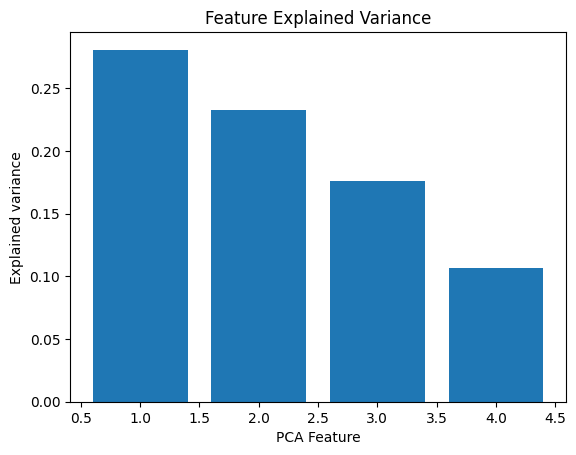

In [ ]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_ratio_
    )
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

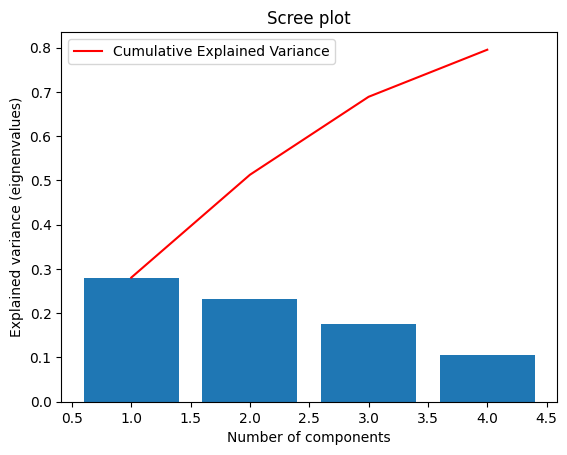

In [ ]:
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_ratio_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_ratio_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

Some useful libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

We load the starting dataset features such that at the end of the clustering we can add a column in it containing cluster indices for each costumer:

In [ ]:
features = pd.read_csv("features.csv")
features=features.drop(['Unnamed: 0'], axis=1)

In [ ]:
# Load the dataframe obtained from the PCA in the previous exercise
data = pd.read_csv('pca_features.csv')
data=data.drop(['Unnamed: 0'], axis=1)
data = data.values
data

array([[ 0.02159565,  0.37953109, -0.02801758,  0.15395317],
       [-0.07346689, -0.04242453, -0.1093801 , -0.11240164],
       [-0.11900419,  0.28492005,  0.27558898, -0.0786157 ],
       ...,
       [ 0.08943892, -0.05039707, -0.10210086, -0.05800698],
       [-0.14862432, -0.03563719, -0.11919064, -0.04942727],
       [ 0.22495462, -0.04799951, -0.08238435, -0.04938467]])

# 2.3 Clustering!

## Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class. !! We also ask you to use MapReduce in your K-means algorithm.

In [ ]:
k = 4 #optimal number of clusters found with the Elbow method below

# First, we randomly initialize the centroids
centroids = np.random.rand(k, data.shape[1])

# Then, we define a function to compute the distance between two points
def distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

# Define a function to assign each data point to the closest centroid
def assign_points_to_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = [distance(point, centroid) for centroid in centroids]
        cluster_idx = np.argmin(distances)
        clusters.append(cluster_idx)
    return clusters

# Define a function to update the centroids
def update_centroids(data, clusters, centroids):
    for i in range(k):
        cluster_points = [data[j] for j in range(len(data)) if clusters[j] == i]
        centroids[i] = np.mean(cluster_points, axis=0)

# Define a function to run the k-means algorithm
def my_kmeans(data, k, centroids):
    # Repeat the following steps until convergence
    while True:
        # Assign each point to the closest centroid
        clusters = assign_points_to_clusters(data, centroids)

        # Store the old centroids
        old_centroids = centroids.copy()

        # Update the centroids
        update_centroids(data, clusters, centroids)

        # Check for convergence
        if np.array_equal(old_centroids, centroids):
            break

# Define the MapReduce function
def map_reduce(data, map_func, reduce_func):
    # Divide the data into chunks
    chunks = np.array_split(data, 4) #4 is the number of cores of my computer

    # Map the data
    mapped_data = []
    for chunk in chunks:
        mapped_data.append(map_func(chunk))

    # Reduce the data
    reduced_data = reduce_func(mapped_data)

    return reduced_data

# Define the map function
def map_kmeans(chunk):
    # Initialize the centroids
    local_centroids = np.random.rand(k, data.shape[1])

    # Run the k-means algorithm
    my_kmeans(chunk, k, local_centroids)

    return local_centroids

# Define the reduce function
def reduce_kmeans(local_centroids):
    
    # Compute the global centroids
    global_centroids = np.mean(local_centroids, axis=0)

    return global_centroids

## Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

To find the optimal number of clusters in the k-means algorithm, it is possible to use the following methods:

### The elbow method:

The WCSS is a measure of the compactness of the clusters, with smaller values indicating better clustering. The elbow method involves plotting the WCSS against k, and selecting the value of k where the WCSS starts to decrease more slowly. This value of k is considered to be the optimal number of clusters.

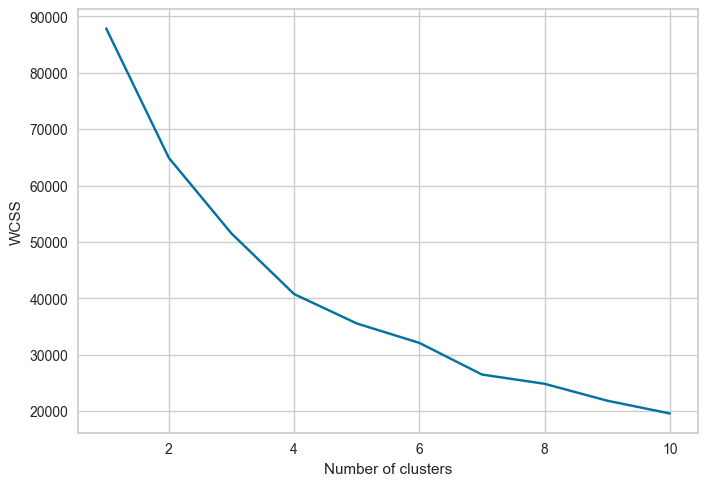

In [ ]:
# Create an empty list to store the WCSS values
WCSS = []

# Loop over different values of i
for i in range(1, 11):
    # Create a k-means model with the current value of i
    kmeans_py = KMeans(n_clusters=i)

    # Fit the model to the data
    kmeans_py.fit(data)

    # Compute the WCSS for the current model
    WCSS.append(kmeans_py.inertia_)

# Plot the WCSS values
plt.plot(range(1, 11), WCSS)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

As we can see from the graph, the optimal number of clusters following the Elbow method is 4.

### The silhouette coefficient

The silhouette coefficient method involves computing the average silhouette coefficient for each value of k, and selecting the value of k that produces the highest average silhouette coefficient. This value of k is considered to be the optimal number of clusters.

In [ ]:
# Create an empty list to store the silhouette coefficients
silhouette_coefficients = []

# Loop over different values of k
for k in range(2, 9):
    # Create a k-means model with the current value of k
    kmeans = KMeans(n_clusters=k)

    # Fit the model to the data
    kmeans.fit(data)

    # Compute the silhouette coefficient for the current model
    silhouette_coefficients.append(silhouette_score(data, kmeans.labels_))

# Plot the silhouette coefficient values
plt.plot(range(2, 9), silhouette_coefficients)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')
plt.show()

KeyboardInterrupt: 

We tried to implement the silhouette coefficient method but we don't know why it takes too much time to run, so we had to interrupt it. So, in the end, we chose 4 as number of clusters as visualized in the graph of the Elbow Method.

### Run the algorithm on the data.

In [ ]:
# Run the MapReduce function
global_centroids=map_reduce(data, map_kmeans, reduce_kmeans)

 We save them in an external file such that we don't have to run the code every time for several minutes

In [ ]:
np.savetxt('global_centroids.csv', global_centroids, delimiter=',')

Once we get global centroids computed by the k-means algorithm, we use them to cluster the data points into the specified number of clusters.
The assign_points_to_clusters function only assigns the data points to the closest cluster based on the given centroids. It does not compute the final clusters or update the centroids. To compute the final clusters and update the centroids, we need to run the kmeans function before calling the assign_points_to_clusters function. This will run the k-means algorithm and update the centroids until convergence, and then the assign_points_to_clusters function can be used to assign the data points to the clusters based on the final centroids.

In [ ]:
# Run the k-means algorithm to compute the final clusters and update the centroids for my data
my_kmeans(data, k, global_centroids)

In [ ]:
# Assign the data points to the closest cluster
cluster_indices = assign_points_to_clusters(data, global_centroids)

In [ ]:
#We add this cluster indices array as a column of our starting dataset "features"
features['clus_ind']=0
for i in range(len(features)):
    features['clus_ind'][i]=cluster_indices[i]

C:\Users\feder\AppData\Local\Temp\ipykernel_15488\3730380774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['clus_ind'][i]=cluster_indices[i]


In [ ]:
#then, we save it as a csv file
features.to_csv('features.csv')

### Then, use the already implemented version of K-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.

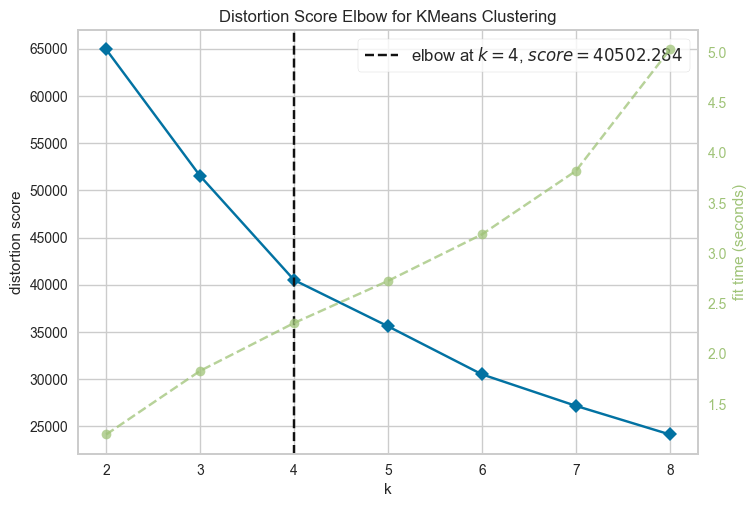

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,9), metric = "distortion")
visualizer.fit(data)
visualizer.show()

As can be seen in the graph of the already implemented method of K-means, the elbow of python implemented version of K-means is the same as above, getting 4 as optimal cluster number. 

# 2.4 Analysing your results!

### Select 2-3 variables you think are relevant to identify the cluster of the customer

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
features = pd.read_csv("features.csv")
features=features.drop(['Unnamed: 0'], axis=1)

In [ ]:
features.head(5)

,CustomerID,n_transactions,n_transactions_100,average_amount,average_balance,utilisation,common_gender,frequent_location,min_trans,max_trans,...,earliest_TransactionTime,latest_TransactionTime,first_half_transactions,second_half_transactions,first_months_transactions,last_months_transactions,median_amount,first_quartile_amount,third_quartile_amount,clus_ind
0,C1010011,2,2,2553.0,76340.635,73787.635,['F' 'M'],['NEW DELHI' 'NOIDA'],356.0,4750.0,...,01:12:29,12:38:13,1,1,0,2,2553.0,1454.50,3651.50,1
1,C1010012,1,1,1499.0,24204.490,22705.490,M,MUMBAI,1499.0,1499.0,...,20:44:09,20:44:09,0,1,0,1,1499.0,1499.00,1499.00,3
2,C1010014,2,2,727.5,100112.950,99385.450,['F' 'M'],MUMBAI,250.0,1205.0,...,15:44:51,22:03:05,0,2,1,1,727.5,488.75,966.25,0
3,C1010018,1,0,30.0,496.180,466.180,F,CHAMPARAN,30.0,30.0,...,17:02:54,17:02:54,0,1,0,1,30.0,30.00,30.00,2
4,C1010024,1,1,5000.0,87058.650,82058.650,M,KOLKATA,5000.0,5000.0,...,14:11:03,14:11:03,0,1,0,1,5000.0,5000.00,5000.00,3


The 3 variables we think are relevant to identify the cluster of the customers are 'common_gender', 'utilisation', 'average_amount' and 'n_transactions'. We define an empty dataframe and we work starting from it. 

In [ ]:
df =  pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False) 

In [ ]:
df['cluster']=features['clus_ind']
df["Gender"] = features["common_gender"].values
df["utilisation"] = features["utilisation"].values               
df["Average_transaction_amount"] = features["average_amount"].values
df["n_transactions"] = features["n_transactions"].values

In [ ]:
df["utilisation"]

0          73787.635
1          22705.490
2          99385.450
3            466.180
4          82058.650
             ...    
884260    132376.230
884261     95841.460
884262      5433.750
884263     35245.920
884264      6113.930
Name: utilisation, Length: 884265, dtype: float64

### Most of your selected variables will be numerical (continuous or discrete), then categorise them into four categories.

We divide 'utilisation' in 4 classes:

In [ ]:
df.utilisation[df.utilisation < 4000] = 1
df.utilisation[(df.utilisation >= 4000) & (df.utilisation < 20000)] = 2
df.utilisation[(df.utilisation >= 20000) & (df.utilisation < 50000 )] = 3
df.utilisation[df.utilisation >= 50000] = 4

C:\Users\feder\AppData\Local\Temp\ipykernel_19740\3616360209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.utilisation[df.utilisation < 4000] = 1
C:\Users\feder\AppData\Local\Temp\ipykernel_19740\3616360209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.utilisation[(df.utilisation >= 4000) & (df.utilisation < 20000)] = 2
C:\Users\feder\AppData\Local\Temp\ipykernel_19740\3616360209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

Then, we divide 'Average_transaction_amount' in 4 categories:

In [ ]:
df.Average_transaction_amount[df.Average_transaction_amount < 200] = 1
df.Average_transaction_amount[(df.Average_transaction_amount >= 200) & (df.Average_transaction_amount < 500)] = 2
df.Average_transaction_amount[(df.Average_transaction_amount >= 500) & (df.Average_transaction_amount < 1000 )] = 3
df.Average_transaction_amount[df.Average_transaction_amount >= 1000] = 4

C:\Users\feder\AppData\Local\Temp\ipykernel_19740\405205566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Average_transaction_amount[df.Average_transaction_amount < 200] = 1
C:\Users\feder\AppData\Local\Temp\ipykernel_19740\405205566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Average_transaction_amount[(df.Average_transaction_amount >= 200) & (df.Average_transaction_amount < 500)] = 2
C:\Users\feder\AppData\Local\Temp\ipykernel_19740\405205566.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

And, in the end we create 4 categories for the variable 'n_transactions':

In [ ]:
df.n_transactions[df.n_transactions <= 1] = 1
df.n_transactions[(df.n_transactions == 1) & (df.n_transactions == 2)] = 2
df.n_transactions[(df.n_transactions == 3) & (df.n_transactions == 4 )] = 3
df.n_transactions[df.n_transactions >= 4] = 4

C:\Users\feder\AppData\Local\Temp\ipykernel_19740\1663845779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.n_transactions[df.n_transactions <= 1] = 1
C:\Users\feder\AppData\Local\Temp\ipykernel_19740\1663845779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.n_transactions[(df.n_transactions == 1) & (df.n_transactions == 2)] = 2
C:\Users\feder\AppData\Local\Temp\ipykernel_19740\1663845779.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [ ]:
df.head(5)

,cluster,Gender,utilisation,Average_transaction_amount,n_transactions
0,1,['F' 'M'],4.0,4.0,2
1,3,M,3.0,4.0,1
2,0,['F' 'M'],4.0,3.0,2
3,2,F,1.0,1.0,1
4,3,M,4.0,4.0,1


### With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable. Calculate the percentage by column for each pivot table. The sum of each row (cluster) must be 100.

We first define an empty pivot table dataframe:

In [ ]:
p_t=pd.DataFrame(data=None, index=None, columns=None, dtype=None, copy=False)  

Then, we start filling it with the percentage by column for each pivot table:

In [ ]:
p_t["F"] = round(df.groupby("cluster")["Gender"].apply(lambda x : (x =="F").sum()/((x == "F").sum()+(x == "M").sum())*100), 2)
p_t["M"] = round(df.groupby("cluster")["Gender"].apply(lambda x : (x =="M").sum()/((x == "F").sum()+(x == "M").sum())*100), 2)

In [ ]:
p_t[["M","F"]]

,M,F
cluster,,
0,73.41,26.59
1,87.04,12.96
2,76.03,23.97
3,71.73,28.27


As can be seen from the pivot table, the second cluster stands out from the others in terms of the percentage of male components, presenting a higher percentage. The other clusters, on the other hand, have a rather homogeneous percentage.

In [ ]:
p_t["Low_utilisation"] = round(df.groupby("cluster")["utilisation"].apply(lambda x: (x == 1).sum()/x.count()*100), 2)
p_t["Middle_low_utilisation"] = round(df.groupby("cluster")["utilisation"].apply(lambda x: (x == 2).sum()/x.count() * 100 ), 2)
p_t["Middle_high_utilisation"] = round(df.groupby("cluster")["utilisation"].apply(lambda x: (x == 3).sum()/x.count()*100), 2)
p_t["High_utilisation"] = round(df.groupby("cluster")["utilisation"].apply(lambda x:(x == 4).sum()/x.count()*100), 2)

In [ ]:
p_t[["Low_utilisation","Middle_low_utilisation","Middle_high_utilisation","High_utilisation"]]

,Low_utilisation,Middle_low_utilisation,Middle_high_utilisation,High_utilisation
cluster,,,,
0,6.67,33.82,24.12,35.38
1,15.35,36.64,21.23,26.77
2,62.95,34.85,2.20,0.00
3,0.04,22.35,29.38,48.23


Looking instead at the utilization pivot table, the clusters turn out to be better defined and heterogeneous: while the third cluster encompasses the elements of the lower-middle range of utilization, more than 70% of the members of the fourth cluster have a medium-high level of utilization. The first two clusters, on the other hand, are the average clusters most characterized by customers with an average level of utilization.

In [ ]:
p_t["Low_transaction_amount"] = round(df.groupby("cluster")["Average_transaction_amount"].apply(lambda x: (x == 1).sum()/x.count()*100), 2)
p_t["Middle_low_transaction_amount"] = round(df.groupby("cluster")["Average_transaction_amount"].apply(lambda x: (x == 2).sum()/x.count() * 100 ), 2)
p_t["Middle_high_transaction_amount"] = round(df.groupby("cluster")["Average_transaction_amount"].apply(lambda x: (x == 3).sum()/x.count()*100), 2)
p_t["High_transaction_amount"] = round(df.groupby("cluster")["Average_transaction_amount"].apply(lambda x:(x == 4).sum()/x.count()*100), 2)

In [ ]:
p_t[["Low_transaction_amount","Middle_low_transaction_amount","Middle_high_transaction_amount","High_transaction_amount"]]

,Low_transaction_amount,Middle_low_transaction_amount,Middle_high_transaction_amount,High_transaction_amount
cluster,,,,
0,27.48,24.50,18.13,29.89
1,12.82,24.58,23.56,39.04
2,32.67,22.03,15.33,29.97
3,22.93,24.83,20.74,31.49


Looking at the transaction amount pivot table, it is interesting to note that the second cluster, the one with a higher percentage of male users, also turns out to have the highest average transactions.

In [ ]:
p_t["Low_n_transactions"] = round(df.groupby("cluster")["n_transactions"].apply(lambda x: (x == 1).sum()/x.count()*100), 2)
p_t["Middle_low_n_transactions"] = round(df.groupby("cluster")["n_transactions"].apply(lambda x: (x == 2).sum()/x.count() * 100 ), 2)
p_t["Middle_high_n_transactions"] = round(df.groupby("cluster")["n_transactions"].apply(lambda x: (x == 3).sum()/x.count()*100), 2)
p_t["High_n_transactions"] = round(df.groupby("cluster")["n_transactions"].apply(lambda x:(x == 4).sum()/x.count()*100), 2)

In [ ]:
p_t[["Low_n_transactions","Middle_low_n_transactions","Middle_high_n_transactions","High_n_transactions"]]

,Low_n_transactions,Middle_low_n_transactions,Middle_high_n_transactions,High_n_transactions
cluster,,,,
0,85.53,14.35,0.12,0.00
1,0.00,79.85,18.11,2.04
2,98.44,1.56,0.00,0.00
3,93.31,6.69,0.00,0.00


A similar argument to the previous pivot table can be made by observing that of the number of transactions: the second cluster, in addition to being the one with a higher percentage of male components and a higher percentage of transaction amount, also turns out to be the cluster with the largest number of transactions executed as a percentage.